In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision import datasets, models, transforms

import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
from torch.optim import lr_scheduler
from PIL import Image
import PIL.ImageOps    
import torch.nn.functional as F
import pandas as pd 

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [2]:
class DepressingNet(nn.Module):
    
    def __init__(self, model):
        super(DepressingNet, self).__init__()
        self.model = model
        self.output_layer = nn.Sequential(nn.Linear(50,1))

    def forward(self, inp):
        out = self.model(inp)
        res = self.output_layer(out)
        return res

In [3]:
model_ft = models.vgg11_bn(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,50)
model = DepressingNet(model_ft)

model.load_state_dict(torch.load('0_3lossmodel.pt'))

In [4]:
newhavendf = pd.read_csv('newhaven.csv')
newhavendf.head()

,filename,latitude,longitude,date,scores
0,3372.jpg,41.313540,-72.944976,2018-06,0
1,10112.jpg,41.319315,-72.891715,2017-08,0
2,9380.jpg,41.315765,-72.967963,2015-08,1
3,2755.jpg,41.304977,-72.932415,2018-07,0
4,4602.jpg,41.318509,-72.912834,2017-07,1


In [5]:
newhavendf.shape

(14873, 5)

In [6]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                      ])
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    
def open_image(name):
    path = os.path.join('/home/alphonsus/urban_planning/CONNECTICUT_IMAGES/NEWHAVEN_IMAGES/', str(name))
    image = Image.open(path)
    img = transform(image) 
    return img
    

In [7]:
model=model.to('cuda:0')
dep_scores=[]
count = 0
for i in newhavendf['filename']:
    img = open_image(i).unsqueeze(0)
    img = img.to('cuda:0')
    res = model(img)
    r = res.item()
    dep_scores.append(r)
    count+=1
    if count%1000==0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [8]:
np.max(dep_scores)

25.802330017089844

In [9]:
np.min(dep_scores)

24.358198165893555

In [10]:
del newhavendf['scores']
newhavendf['depressing_score']=dep_scores 
newhavendf.head()

,filename,latitude,longitude,date,depressing_score
0,3372.jpg,41.313540,-72.944976,2018-06,24.782185
1,10112.jpg,41.319315,-72.891715,2017-08,25.156658
2,9380.jpg,41.315765,-72.967963,2015-08,25.377102
3,2755.jpg,41.304977,-72.932415,2018-07,24.720947
4,4602.jpg,41.318509,-72.912834,2017-07,24.897919


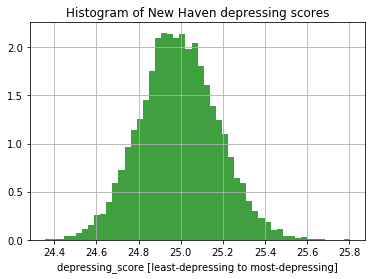

In [11]:
n, bins, patches = plt.hist(newhavendf['depressing_score'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('depressing_score [least-depressing to most-depressing]')
# plt.ylabel('Number of datapoints')
plt.title('Histogram of New Haven depressing scores')
plt.grid(True)
plt.show()

In [12]:
newhavendf.to_csv('newhaven_dep_scores.csv',index=False)